<a href="https://colab.research.google.com/github/xy2119/Data_Mining/blob/main/Recommender_System/GAE_VGAE_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Edge level prediction pretrained with GAE/VGAE

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

#!git clone https://github.com/dmlc/dgl.git
!pip install dgl
!pip install --upgrade gensim
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
import pandas as pd
import numpy as np

import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import random
random.seed(2022)
np.random.seed(2022)
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving multi_attribution_sample.csv to multi_attribution_sample (1).csv
Saving revenue_deepwalk.model to revenue_deepwalk (1).model
Saving REVENUE_edge_index.csv to REVENUE_edge_index (1).csv
Saving revenue_Node2Vec.model to revenue_Node2Vec (1).model


In [ ]:
import io
df=pd.read_csv(io.BytesIO(uploaded['multi_attribution_sample.csv']))
col=df.columns
y=torch.from_numpy(np.array((df[col[-1]]))).reshape(df.shape[0],1).to(torch.float32)
x=torch.from_numpy(np.array(df[col[:-1]])).to(torch.float32)


In [ ]:
edge_index=pd.read_csv(io.BytesIO(uploaded['REVENUE_edge_index.csv']))
edge_index=torch.from_numpy(np.transpose(np.array(edge_index)))

In [ ]:
from gensim.models import word2vec
model_dw=word2vec.Word2Vec.load("revenue_deepwalk.model")
model_n2v=word2vec.Word2Vec.load("revenue_Node2Vec.model")

lst_dw=[]
lst_n2v=[]
for i in range(10):
    lst_dw.append(model_dw.wv[i])
    lst_n2v.append(model_n2v.wv[i])
len(lst_n2v)

10

In [ ]:
import torch
from torch_geometric.data import InMemoryDataset, download_url

#训练数据集
class MyData(InMemoryDataset):
    def __init__(self, root,transform=None, pre_transform=None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
       # ,self.edge_index,self.y=x,edge_index,y
        
    #返回数据集源文件名
    @property
    def raw_file_names(self):
        return ['some_file_1', 'some_file_2', ...]
    #返回process方法所需的保存文件名。你之后保存的数据集名字和列表里的一致
    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        data_list=[]
        for i in range(x.shape[0]):
            Edge_index = edge_index.type(torch.long)
            X =x[i]
            t=torch.zeros(10,11) # 17 = 1+10 = node number, node embedding
                                 # 当前节点、node embedding (10d)、feature (10d)
            
            for j in range(10):
              t[j]=torch.from_numpy(np.concatenate(( [float(X[int(j)])], # 当前节点,对应第j维特征 (1d)
                                                     list(lst_dw[int(j)]), # node embedding (10d) 第j维特征的先验图嵌入,lst_n2v为Node2Vec模型生成的特征嵌入
                                                                                     ))) 
              
            Y = y[i].reshape(-1,1).to(torch.float32)
            data = Data(x=t, edge_index=Edge_index, y=Y)
        # 放入datalist
            data_list.append(data)

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
Mydata=MyData(".\mydata\MYdata")

In [ ]:
Mydata=MyData(".\mydata\MYdata")
Mydata.data

Data(x=[20000, 11], edge_index=[2, 60000], y=[2000, 1])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from torch.autograd import Variable

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Variational Graph Auto-Encoder
class VGAE(nn.Module):
   def __init__(self, **kwargs):
      super(VGAE, self).__init__()
      
      self.num_neurons = kwargs['num_neurons']
      self.num_features = kwargs['num_features']
      self.embedding_size = kwargs['embedding_size']
      
      self.w_0 = VGAE.random_uniform_init(self.num_features, self.num_neurons)
      self.b_0 = torch.nn.init.constant_(nn.Parameter(torch.Tensor(self.num_neurons)), 0.01)
      
      self.w_1_mu = VGAE.random_uniform_init(self.num_neurons, self.embedding_size)
      self.b_1_mu = torch.nn.init.constant_(nn.Parameter(torch.Tensor(self.embedding_size)), 0.01)

      self.w_1_sigma = VGAE.random_uniform_init(self.num_neurons, self.embedding_size)
      self.b_1_sigma = torch.nn.init.constant_(nn.Parameter(torch.Tensor(self.embedding_size)), 0.01)

      
   @staticmethod
   def random_uniform_init(input_dim, output_dim):
      
      init_range = np.sqrt(6.0/(input_dim + output_dim))
      tensor = torch.FloatTensor(input_dim, output_dim).uniform_(-init_range, init_range)
      
      return nn.Parameter(tensor)

   def encode(self, adjacency, norm_adj, x_features):
      
      hidden_0 = torch.relu(torch.add(torch.matmul(torch.matmul(norm_adj, x_features), self.w_0), self.b_0))
      self.GCN_mu = torch.add(torch.matmul(torch.matmul(norm_adj, hidden_0), self.w_1_mu), self.b_1_mu)
      self.GCN_sigma = torch.exp(torch.add(torch.matmul(torch.matmul(norm_adj, hidden_0), self.w_1_sigma), self.b_1_sigma))
      
      z = self.GCN_mu + torch.randn(self.GCN_sigma.size()) * self.GCN_sigma
      
      return z
   
   @staticmethod
   def decode(z):
      x_hat = torch.sigmoid(torch.matmul(z, z.t()))
      return x_hat


   def forward(self, adjacency, norm_adj, x_features):
      z = self.encode(adjacency, norm_adj, x_features)
      x_hat = VGAE.decode(z)
      
      return x_hat

In [ ]:
from dgl.nn.pytorch import GraphConv
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GAE,VGAE
#定义VGAEModel
class VGAEModel(nn.Module):
    def __init__(self, in_dim, hidden1_dim, hidden2_dim):#初始化VGAE
        super(VGAEModel, self).__init__()
        self.in_dim = in_dim#输入特征维度
        self.hidden1_dim = hidden1_dim#两个隐藏层维度
        self.hidden2_dim = hidden2_dim

        #三层GraphConv，原文中生成均值和方差的W0是共享的，W1是不同的，因此一共要三层
        #https://docs.dgl.ai/en/0.6.x/_modules/dgl/nn/pytorch/conv/graphconv.html
        #GraphConv用于实现GCN的卷积
        layers = [GraphConv(self.in_dim, self.hidden1_dim, activation=F.relu, allow_zero_in_degree=True),#第一层，共享参数
                  GraphConv(self.hidden1_dim, self.hidden2_dim, activation=lambda x: x, allow_zero_in_degree=True),#第二层求均值
                  GraphConv(self.hidden1_dim, self.hidden2_dim, activation=lambda x: x, allow_zero_in_degree=True)]#第二层求方差
        self.layers = nn.ModuleList(layers)

    def encoder(self, g, features):
        h = self.layers[0](g, features)#第一层得到输出h
        self.mean = self.layers[1](g, h)#第二层求均值
        self.log_std = self.layers[2](g, h)#第二层求方差
        gaussian_noise = torch.randn(features.size(0), self.hidden2_dim).to(device)#标准高斯分布采样，大小是features_size*hidden2_dim
        sampled_z = self.mean + gaussian_noise * torch.exp(self.log_std).to(device)#这里其实是reparameterization trick，具体看公式1和代码如何对应
        return sampled_z

    def decoder(self, z):
        adj_rec = torch.sigmoid(torch.matmul(z, z.t()))#解码器点乘还原邻接矩阵A'
        return adj_rec

    def forward(self, g, features):#前向传播
        z = self.encoder(g, features)#编码器得到隐变量
        adj_rec = self.decoder(z)#解码器还原邻接矩阵
        return adj_rec

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True) # cached only for transductive learning

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)
        
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VariationalGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


Using backend: pytorch


In [ ]:
import dataclasses
out_channels = 2
num_features = 11
epochs = 512

# model
model = GAE(GCNEncoder(num_features, out_channels)) # encoder: written by us; decoder: default (inner product)

# move to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

data= Mydata.data
data = train_test_split_edges(data) # construct positive/negative edges (for negative sampling!)

x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)
# edge_weights=torch.ones(train_pos_edge_index.shape[1]).to(device)
# num_nodes=x.shape[0]

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


GAE

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encoder(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    #if args.variational:
    #   loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

for epoch in range(1, epochs + 1):
    loss = train()

    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

Epoch: 001, AUC: 0.9152, AP: 0.8549
Epoch: 002, AUC: 0.9152, AP: 0.8549
Epoch: 003, AUC: 0.9152, AP: 0.8549
Epoch: 004, AUC: 0.9152, AP: 0.8549
Epoch: 005, AUC: 0.9152, AP: 0.8549
Epoch: 006, AUC: 0.9152, AP: 0.8549
Epoch: 007, AUC: 0.9152, AP: 0.8549
Epoch: 008, AUC: 0.9152, AP: 0.8549
Epoch: 009, AUC: 0.9152, AP: 0.8549
Epoch: 010, AUC: 0.9152, AP: 0.8549
Epoch: 011, AUC: 0.9152, AP: 0.8549
Epoch: 012, AUC: 0.9152, AP: 0.8549
Epoch: 013, AUC: 0.9152, AP: 0.8549
Epoch: 014, AUC: 0.9152, AP: 0.8549
Epoch: 015, AUC: 0.9152, AP: 0.8549
Epoch: 016, AUC: 0.9152, AP: 0.8549
Epoch: 017, AUC: 0.9152, AP: 0.8549
Epoch: 018, AUC: 0.9152, AP: 0.8549
Epoch: 019, AUC: 0.9152, AP: 0.8549
Epoch: 020, AUC: 0.9152, AP: 0.8549
Epoch: 021, AUC: 0.9152, AP: 0.8549
Epoch: 022, AUC: 0.9152, AP: 0.8549
Epoch: 023, AUC: 0.9152, AP: 0.8549
Epoch: 024, AUC: 0.9152, AP: 0.8549
Epoch: 025, AUC: 0.9152, AP: 0.8549
Epoch: 026, AUC: 0.9152, AP: 0.8549
Epoch: 027, AUC: 0.9152, AP: 0.8549
Epoch: 028, AUC: 0.9152, AP:

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


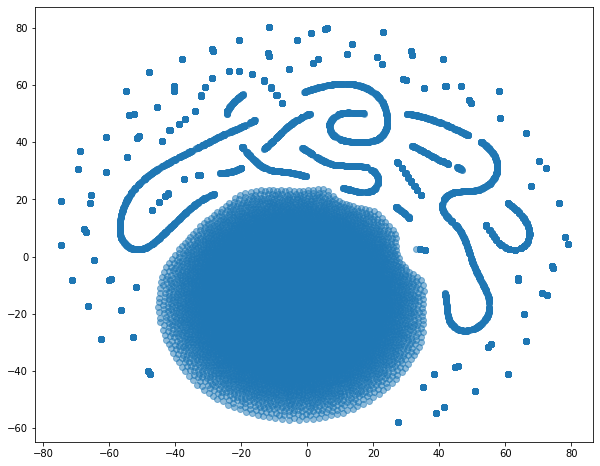

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
labels = data.y

model.eval()
z = model.encode(x, train_pos_edge_index)

xs, ys = zip(*TSNE().fit_transform(z.cpu().detach().numpy()))

plt.figure(figsize=(10, 8))
plt.tight_layout()
plt.scatter(xs, ys, alpha=0.5)
plt.show()

VGAE

In [ ]:
out_channels = 2
num_features = 11
epochs = 512
model = VGAE(VariationalGCNEncoder(num_features, out_channels))  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    
    loss = loss + (1 / data.num_nodes) * model.kl_loss()  
    loss.backward()
    optimizer.step()
    return float(loss)


for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))  

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

Epoch: 001, AUC: 0.8022, AP: 0.7165
Epoch: 002, AUC: 0.8212, AP: 0.7366
Epoch: 003, AUC: 0.8430, AP: 0.7610
Epoch: 004, AUC: 0.8562, AP: 0.7766
Epoch: 005, AUC: 0.8567, AP: 0.7772
Epoch: 006, AUC: 0.8590, AP: 0.7800
Epoch: 007, AUC: 0.8632, AP: 0.7851
Epoch: 008, AUC: 0.8637, AP: 0.7858
Epoch: 009, AUC: 0.8648, AP: 0.7872
Epoch: 010, AUC: 0.8662, AP: 0.7889
Epoch: 011, AUC: 0.8780, AP: 0.8039
Epoch: 012, AUC: 0.8808, AP: 0.8075
Epoch: 013, AUC: 0.8938, AP: 0.8249
Epoch: 014, AUC: 0.8995, AP: 0.8326
Epoch: 015, AUC: 0.9165, AP: 0.8569
Epoch: 016, AUC: 0.9223, AP: 0.8656
Epoch: 017, AUC: 0.9228, AP: 0.8663
Epoch: 018, AUC: 0.9232, AP: 0.8668
Epoch: 019, AUC: 0.9238, AP: 0.8678
Epoch: 020, AUC: 0.9243, AP: 0.8686
Epoch: 021, AUC: 0.9252, AP: 0.8698
Epoch: 022, AUC: 0.9257, AP: 0.8706
Epoch: 023, AUC: 0.9258, AP: 0.8708
Epoch: 024, AUC: 0.9267, AP: 0.8721
Epoch: 025, AUC: 0.9267, AP: 0.8721
Epoch: 026, AUC: 0.9270, AP: 0.8726
Epoch: 027, AUC: 0.9278, AP: 0.8739
Epoch: 028, AUC: 0.9280, AP:

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


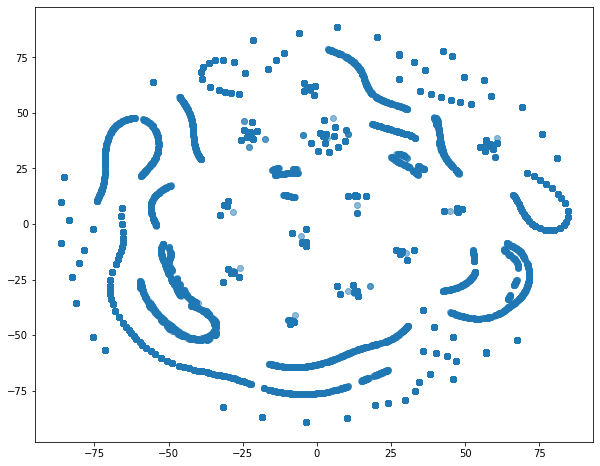

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
labels = data.y
#data.y = None
model.eval()
z = model.encode(x, train_pos_edge_index)


xs, ys = zip(*TSNE().fit_transform(z.cpu().detach().numpy()))

plt.figure(figsize=(10, 8))
plt.tight_layout()
plt.scatter(xs, ys, alpha=0.5)
plt.show()